# Toy Model: 

$$\nabla\,\mathsf{T} = \mathrm{C}\,\mathsf{T} + \mathsf{F}$$ 

where,

$\mathsf{T} = 
\begin{bmatrix}
    \mathsf{T_O} \\
    \mathsf{T_A} 
\end{bmatrix}$ is the vector containing sub-component temperatures,

$\mathsf{F} = 
\begin{bmatrix}
    \emptyset \\
    \mathsf{F}(t) 
\end{bmatrix}$ is the forcing function, usually assumed to be stochastic white noise for the atmospheric component. The diagonal operator $\nabla$ encodes the time-dependent factorisation of the constituent ODEs such that,

$$\nabla = 
\begin{bmatrix}
    \mathsf{m}\displaystyle\frac{\mathsf{d}}{\mathsf{d}t} & \emptyset \\
    \emptyset & \displaystyle\frac{\mathsf{d}}{\mathsf{d}t} 
\end{bmatrix},$$ 

where $\mathsf{m}$ encodes the relative temporal scale, and lastly

$$\mathrm{C} = 
\begin{bmatrix}
    \mathrm{C}_\mathsf{OO} & \mathrm{C}_\mathsf{OA} \\
    \mathrm{C}_\mathsf{AO} & \mathrm{C}_\mathsf{AA} 
\end{bmatrix}$$

is the covariance matrix. The system of equations may be written in coupled form as

$$\displaystyle\mathsf{m}\frac{\mathsf{dT_O}}{\mathsf{d}t} = \mathrm{C}_\mathsf{OO}\mathsf{T_O} + \mathrm{C}_\mathsf{OA}\mathsf{T_A},$$

$$\displaystyle\frac{\mathsf{dT_A}}{\mathsf{d}t} = \mathrm{C}_\mathsf{AO}\mathsf{T_O} + \mathrm{C}_\mathsf{AA}\mathsf{T_A} + \mathsf{F}(t).$$

In the absence of stochastic forcing. i.e. $\mathsf{F}(t) = \emptyset$, the system of coupled ODEs are easily solved using <font color='blue'>scipy.integrate.odeint()</font> to yield the time-series and the auto- and cross-correlations.


In [1]:
# environment
import matplotlib.font_manager as fm
import numpy as np
import random as rand
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from matplotlib.pyplot import gca
import os 
import math as mt
%matplotlib inline

cwd = os.getcwd()
pwd = os.path.abspath(os.path.join(cwd, os.pardir))
fontloc = pwd + '/Fonts/SFMono-Regular.otf'
font = fm.FontProperties(fname = fontloc,size = 8)
prop = fm.FontProperties(fname = fontloc,size = 8)

#ticks font
def ticks(ax, size):
    font = fm.FontProperties(fname = fontloc,size = size)
    for label in ax.get_xticklabels():
        label.set_fontproperties(font)
    for label in ax.get_yticklabels():
        label.set_fontproperties(font)

In [2]:
#sample initial conditions
Toi = 0.1
Tai = 1.0

# model parameters, variables and functions
tune = 0.2            #model tuning parameter
Coo = -1.08 * tune
Coa = 1.0 * tune
Cao = 0.1 * tune
Caa = -1.12 * tune
m = 10.0

# define forcing function (weiner process with <cross-section>)
scale = 1.0           #relative amplitude of stochastic forcing
crosssec = scale * Tai * scale
#crosssec = 0.0

# time series
t_start = 0.0
t_end = 200.0
time_samples = 2000

def autocorr(x,t):
    result = np.correlate(x, x, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples + 1)
    return [lag_time, result]

def crosscorr(x,y,t):
    result = np.correlate(x, y, mode='same')
    lag_time = np.linspace(start = -t.max()/2, stop = t.max()/2, num = time_samples + 1)
    return [lag_time, result]

def f(x,t):
    To = x[0]
    Ta = x[1]
    f0 = (1/m)*(Coo*To + Coa*Ta)
    f1 = Cao*To + Caa*Ta
    return [f0,f1]

t = np.linspace(start=t_start,stop=t_end,num=time_samples + 1)

In [3]:
# solve ODEs
x0 = [Toi,Tai]
soln = odeint(f,x0,t)
To = soln[:,0]
Ta = soln[:,1]

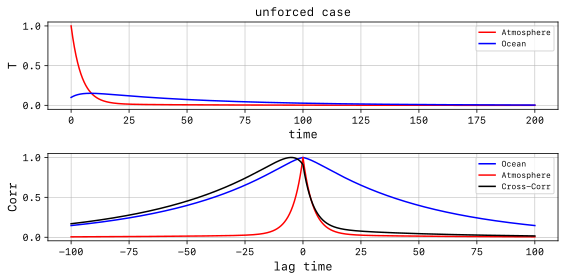

In [4]:
#plot results
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(8,4),dpi=120);
plt.subplot(2, 1, 1)
plt.xlabel('time',fontproperties=font,fontsize=12)
plt.ylabel('T',fontproperties=font,fontsize=12)
plt.plot(t,Ta,'r',t,To,'b')
ax = gca(); ticks(ax,10); ax.set_title('unforced case',fontproperties=font,fontsize=12);
plt.gca().legend(('Atmosphere','Ocean'),prop=prop);
plt.grid(linewidth=0.5); ax.set_axisbelow(True)

[lag_time_To, autocorr_To] = autocorr(To,t)
[lag_time_Ta, autocorr_Ta] = autocorr(Ta,t)
[lag_time_T, crosscorr_T] = crosscorr(Ta,To,t)

plt.subplot(2, 1, 2)
plt.plot(lag_time_To,autocorr_To/float(autocorr_To.max()),'b',lag_time_Ta,autocorr_Ta/float(autocorr_Ta.max()),'r',lag_time_T,crosscorr_T/float(abs(crosscorr_T).max()),'k')
plt.xlabel('lag time',fontproperties=font,fontsize=12)
plt.ylabel('Corr',fontproperties=font,fontsize=12)
ax = gca(); ticks(ax,10)
plt.gca().legend(('Ocean','Atmosphere','Cross-Corr'),prop=prop);
plt.tight_layout(); 
plt.grid(linewidth=0.5); ax.set_axisbelow(True)

In the presence of the stochastic forcing term(s), one must find alternative ways to solve the coupled ODEs as <font color='red'>scipy.integrate.odeint()</font> wouldn't work in this case. We use <font color='blue'>sdeint()</font> in this case.

In [5]:
import sdeint

# set white noise forcing amplitude
W = np.diag([0.0,crosssec])

# redefine unforced part
C = np.array([[(1/m)*Coo, (1/m)*Coa],
              [Cao, Caa]])

def unforc(x, t):
    return C.dot(x)

def forc(x, t):
    return W

soln = sdeint.itoint(unforc,forc,x0,t)
To = soln[:,0]
Ta = soln[:,1]

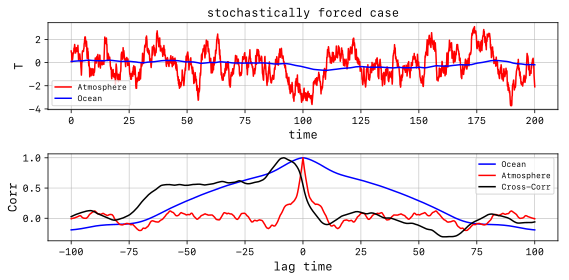

In [6]:
#plot results
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(8,4),dpi=120);
plt.subplot(2, 1, 1)
plt.xlabel('time',fontproperties=font,fontsize=12)
plt.ylabel('T',fontproperties=font,fontsize=12)
plt.plot(t,Ta,'r',t,To,'b')
ax = gca(); ticks(ax,10); ax.set_title('stochastically forced case',fontproperties=font,fontsize=12);
plt.gca().legend(('Atmosphere','Ocean'),prop=prop);
plt.grid(linewidth=0.5); ax.set_axisbelow(True)

[lag_time_To, autocorr_To] = autocorr(To,t)
[lag_time_Ta, autocorr_Ta] = autocorr(Ta,t)
[lag_time_T, crosscorr_T] = crosscorr(Ta,To,t)

plt.subplot(2, 1, 2)
plt.plot(lag_time_To,autocorr_To/float(autocorr_To.max()),'b',lag_time_Ta,autocorr_Ta/float(autocorr_Ta.max()),'r',lag_time_T,crosscorr_T/float(abs(crosscorr_T).max()),'k')
plt.xlabel('lag time',fontproperties=font,fontsize=12)
plt.ylabel('Corr',fontproperties=font,fontsize=12)
ax = gca(); ticks(ax,10)
plt.gca().legend(('Ocean','Atmosphere','Cross-Corr'),prop=prop);
plt.tight_layout();
plt.grid(linewidth=0.5); ax.set_axisbelow(True)

We are able to reproduce the asymmetry in cross-correlation between oceanic and atmospheric states. This asymmetry is a function of the initial temperature anomalies and the forcing function $\mathsf{F}$. 



# Variance in peak cross-correlation

In order to quantify to variance in peak cross-correlation, we run an experiment where a distribution of initial conditions is considered. 

In [7]:
#solve the system of ODEs with a sample set of initial conditions
samples = 200
Toi_lim = 0.1      #maximum amplitude of variability in ocean
Tai_lim = 1.0      #maximum amplitude of variability in atmosphere
peak_corr = []
To_l = []; Ta_l = []

#set DA vars
assim_step = 1.0
DA_step = 0.0      #redundant for now <>

def assim_data(x, y, t, step):
    x_assim = []; y_assim = []; t_assim = []
    for num, time in enumerate(t):
        if time % step == 0.0:
            x_assim.append(x[num])
            y_assim.append(y[num])
            t_assim.append(time)
        else:
            continue
    return x_assim, y_assim, t_assim

def KalCorr(x,y,t):
    result = np.correlate(x, y, mode='same')
    return list(result)

def KalGain(ocean, atmos, t, win):
    ocean_assim, atmos_assim, time_assim = assim_data(ocean, atmos, t, assim_step)
    ind = 0; KalG = []; oce = []; atm = []; tim = []
    for num, time in enumerate(time_assim):
        if time % win == 0.0 and num > 0:
            ind = ind + 1
            oce.append(ocean_assim[num])
            atm.append(np.mean(atmos_assim[num - win:num + 1]))
            tim.append(time)
            kal = KalCorr(atm,oce,tim)
            KalG.append(kal)
        else:
            continue
    return KalG

KalGainList = []

for i in range(samples):
    x0 = [rand.uniform(-Toi_lim, Toi_lim), rand.uniform(-Tai_lim, Tai_lim)]
    soln = sdeint.itoint(unforc,forc,x0,t)
    To_t = soln[:,0]; To_l.append(To_t)    #list with all oceanic temperatures per sample
    Ta_t = soln[:,1]; Ta_l.append(Ta_t)    #list with all atmospheric temperatures per sample
    [lag_time, crosscor] = crosscorr(Ta_t,To_t,t)
    max_index = np.argmax(crosscor)
    peak_corr.append(abs(lag_time[max_index]))
    
    #save data for further analysis of LACC
    max_corr = mt.ceil(abs(lag_time[max_index]))
    KalmanGain = KalGain(To_t, Ta_t, t, max_corr)
    KalGainList.append(KalmanGain)
    
KalTraj = []; KalTrajMax = []
for item in np.arange(0, samples):
    KalTraj.append(KalGainList[item][-1])
    KalTrajMax.append(max(KalGainList[item][-1]))

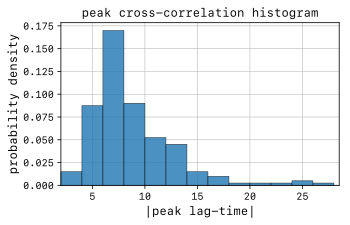

In [8]:
#plot cross-corr statistics
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(5,3),dpi=130);
binsize = 2.0
bins = np.arange(min(lag_time), max(lag_time), binsize)
plt.xlim([min(peak_corr) - 1, max(peak_corr) + 1]);
plt.hist(peak_corr, bins=bins, alpha=0.8, density=True, edgecolor='black', linewidth=0.5);
plt.title('peak cross-correlation histogram',fontproperties=font,fontsize=12);
plt.xlabel('|peak lag-time|',fontproperties=font,fontsize=12)
plt.ylabel('probability density',fontproperties=font,fontsize=12); 
ax = gca(); ticks(ax,10); 
plt.grid(linewidth=0.5); ax.set_axisbelow(True); 

# Leading average cross-correlation (LACC)

Considering LACC [[Liu15](https://www.dropbox.com/s/0bmtizuck5yafto/Lu15a.pdf?dl=0)] and the results in previous section, the Kalman gain is maximised when the average of $\mathsf{N}$ leading atmospheric forecasts are selected for the analysis step in SCDA. This dependence of Kalman gain on leading forecasts is written as

$$\mathsf{K} \propto \langle\mathsf{T_O}(t)\,\overline{\mathsf{T_A}(t_1,t_2)}\rangle$$

where, $t_1 < t_2 \leq t$ contains $\mathsf{N}$ leading atmospheric forecasts. In principle, in regions where the oceanic and atmopheric forecasts are strongly correlated, deviations from the forecasts, as obtained through observations, provide the highest signal-to-noise ratio (SNR) for the analysis step of the DA. This is the core ideology behind the [LACC](https://www.dropbox.com/s/0bmtizuck5yafto/Lu15a.pdf?dl=0) method. 

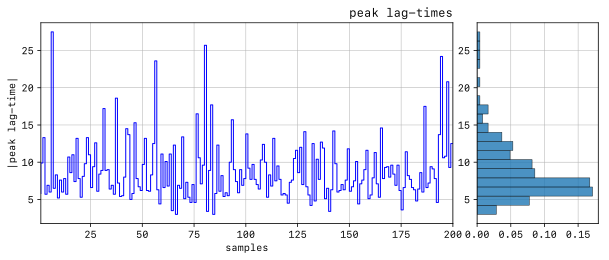

In [32]:
from matplotlib.gridspec import GridSpec
%config InlineBackend.figure_format = 'svg'

#make rows equal lengths for plotting
maxLen = max(map(len, KalTraj))
a = float('nan')
for row in KalTraj:
    if len(row) < maxLen:
        row.extend(a for _ in range(maxLen - len(row)))
        
#plot kalman gain statistics vs lag-times
fig = plt.figure(figsize=(10,5), dpi=200);
gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.step(np.arange(1, samples + 1), np.abs(peak_corr), 'b',linewidth=1.0)
ax_marg_y.hist(np.abs(peak_corr),orientation="horizontal",alpha=0.8, density=True, edgecolor='black', linewidth=0.5, bins = 20)
ticks(ax_joint,10); ticks(ax_marg_y,10); 
ax_joint.grid(linewidth=0.5); ax_joint.set_axisbelow(True);
ax_joint.autoscale(enable=True, axis='x', tight=True)

# Turn off tick labels on marginals
plt.setp(ax_marg_y.get_yticklabels(), visible=True)
plt.grid(linewidth=0.5); ax_marg_y.set_axisbelow(True);

# Set labels on joint
ax_joint.set_xlabel('samples',fontproperties=font,fontsize=10)
ax_joint.set_ylabel('|peak lag-time|',fontproperties=font,fontsize=10);
ax_joint.set_title('peak lag-times',fontproperties=font,fontsize=12, loc='right');

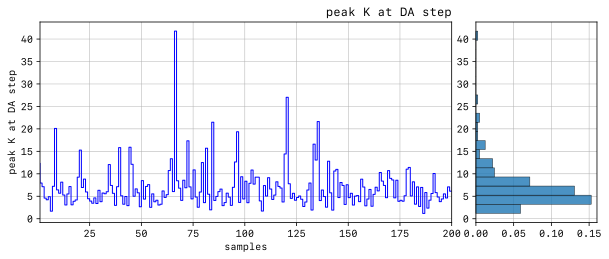

In [33]:
from matplotlib.gridspec import GridSpec
%config InlineBackend.figure_format = 'svg'
        
#plot kalman gain statistics vs DA steps
fig = plt.figure(figsize=(10,5), dpi=200);
gs = GridSpec(4,4)
ax_joint = fig.add_subplot(gs[1:4,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.step(np.arange(1, samples + 1), KalTrajMax, 'b',linewidth=1.0)
ax_marg_y.hist(KalTrajMax,orientation="horizontal",alpha=0.8, density=True, edgecolor='black', linewidth=0.5, bins = 20)
ticks(ax_joint,10); ticks(ax_marg_y,10); 
ax_joint.grid(linewidth=0.5); ax_joint.set_axisbelow(True);
ax_joint.autoscale(enable=True, axis='x', tight=True)

# Turn off tick labels on marginals
plt.setp(ax_marg_y.get_yticklabels(), visible=True)
plt.grid(linewidth=0.5); ax_marg_y.set_axisbelow(True);

# Set labels on joint
ax_joint.set_xlabel('samples',fontproperties=font,fontsize=10)
ax_joint.set_ylabel('peak K at DA step',fontproperties=font,fontsize=10);
ax_joint.set_title('peak K at DA step',fontproperties=font,fontsize=12, loc='right');

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
%config InlineBackend.figure_format = 'svg'

#plot K per sample
fig, ax = plt.subplots(figsize=(12,5), dpi=200);
plt.subplot(2, 1, 1)
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel('sample number',fontproperties=font,fontsize=10)
plt.ylabel('|peak lag-time|',fontproperties=font,fontsize=10)
plt.step(np.arange(1, samples + 1), np.abs(peak_corr), 'b',linewidth=1.0)
ax = gca(); ticks(ax,10); ax.set_title('peak cross-correlation',fontproperties=font,fontsize=12, loc='right');
plt.grid(linewidth=0.5); ax.set_axisbelow(True); ax.set_aspect(1.0)
        
#draw trajectories of Kalman Gain
fig, ax = plt.subplots(figsize=(12,12), dpi=200);
im = ax.matshow(np.array(KalTraj).transpose(),origin='lower');
ax.grid(which='minor')
ax.set_aspect(1.0)

#colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="3%", pad = 0.1)
cb = plt.colorbar(im, cax=cax,label='K',orientation="horizontal");
axc = cb.ax
text = axc.yaxis.label
text.set_font_properties(prop)
ticks(axc,10);

ax.set_xlabel('sample number',fontproperties=font,fontsize=10); 
ax.xaxis.set_label_position('top');
ax.set_ylabel('DA step',fontproperties=font,fontsize=10); 

ticks(ax,10); ax.set_title('Kalman gain trajectories',fontproperties=font,fontsize=12, y=1.1, loc='right');